In [ ]:
import netket as nk
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
from itertools import product
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n = 6          # number of visible units
alpha = 3        # hidden density => m = alpha * n
m = alpha * n

model = nk.models.RBM(alpha=alpha, param_dtype=jnp.complex64)  



In [60]:
def param_init(seed, shape, dtype="complex", sigma=(1.0, 1.0, 1.0)):
    n, m = shape
    sigma_a, sigma_b, sigma_w = sigma

    rng = np.random.default_rng(seed)

    def complex_rand(shape):
        return (rng.normal(size=shape) + 1j * rng.normal(size=shape)) / np.sqrt(2)

    if dtype == "complex":
        params = {
            "a": sigma_a * complex_rand((n,)),
            "b": sigma_b * complex_rand((m,)),
            "W": (sigma_w / np.sqrt(n)) * complex_rand(shape),
        }
    else:
        params = {
            "a": sigma_a * rng.normal(size=(n,)),
            "b": sigma_b * rng.normal(size=(m,)),
            "W": (sigma_w / np.sqrt(n)) * rng.normal(size=shape),
        }

    return params


In [61]:
# def Energy(params, v):
#     """
#     Energy for a single configuration v in {-1,+1}^n:
#     E(v) = -a^T v - sum_j log(2 cosh(b_j + (W^T v)_j))
#     """
#     a, b, W = params["a"], params["b"], params["W"]
#     u = b + v @ W
#     return - jnp.dot(a, v) - jnp.sum(jnp.log(2.0 * jnp.cosh(u)))

def ntk_closed_form(params, V):
    """
    Computes K = B + T T^T + B ⊙ (T T^T)
    where:
      B = V V^T
      U = V W + 1 b^T, T = tanh(U)
    """
    a, b, W = params["a"], params["b"], params["W"]
    U = V @ W + b  # (N, m)
    T = jnp.tanh(U)  # (N, m)
    B = V @ V.T      # (N, N)
    TT = T @ T.T     # (N, N)
    K = B + TT + B * TT
    return K


In [66]:
# key_data = jax.random.PRNGKey(123)
# V = jnp.where(jax.random.normal(key_data, (32, n)) > 0, 1.0, -1.0)  # (N=32, n)

V = configs = jnp.array(list(product([-1, 1], repeat=n))) # (N=2^n, n)

params = param_init(seed=0, shape=(n, m), dtype="real", sigma=(1.0, 1.0, 1.0))
# import time
# tm = time.time()
NTK = ntk_closed_form(params, V)
# print("Closed-form NTK time:", time.time() - tm)

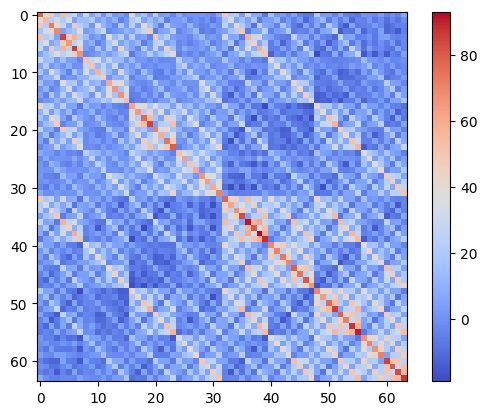

In [69]:
plt.imshow(np.real(NTK), cmap='coolwarm')
plt.colorbar()